In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models
from torchvision import datasets, transforms
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import wandb

In [2]:
# Define transforms for the dataset (with grayscale conversion)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert image to grayscale with 1 channel
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
  # Update mean and std for grayscale
])

# Load dataset
dataset = datasets.ImageFolder(root="D:/trashnet/dataset-resized", transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [3]:
# Load a pre-trained model (without final layer)
feature_extractor = models.resnet18(pretrained=True)
feature_extractor.fc = torch.nn.Identity()  # Remove the classification layer to get features

# Extract features for all images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)
feature_extractor.eval()

features = []
labels = []

with torch.no_grad():
    for images, lbls in data_loader:
        images = images.to(device)
        output = feature_extractor(images)
        features.extend(output.cpu().numpy())
        labels.extend(lbls.numpy())

C:\Users\azzam\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\azzam\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Convert features and labels to numpy arrays
features = np.array(features)
labels = np.array(labels)

In [5]:
# Apply SMOTE to balance the classes
smote = SMOTE()
features_resampled, labels_resampled = smote.fit_resample(features, labels)

# Split resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_resampled, labels_resampled, test_size=0.2, stratify=labels_resampled
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

C:\Users\azzam\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\azzam\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


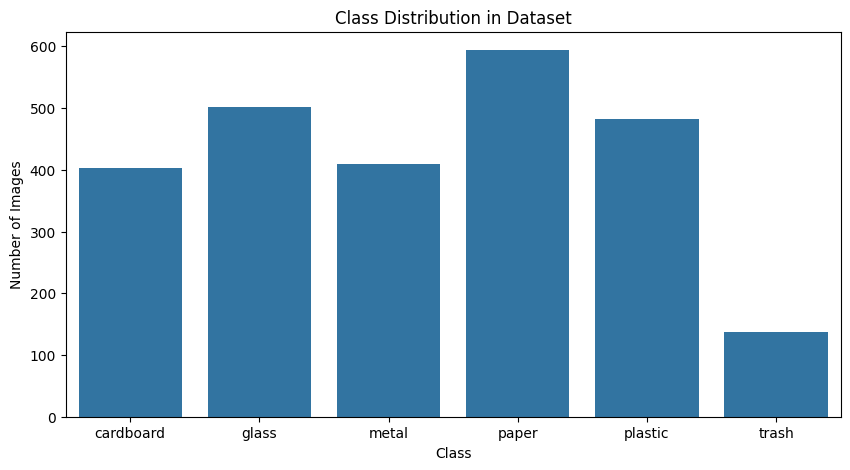

In [6]:
# Exploratory Image Analysis
labels = [label for _, label in dataset]
# 1. Melihat distribusi kelas
label_counts = Counter(labels)
classes = dataset.classes

# Plot distribusi kelas
plt.figure(figsize=(10, 5))
sns.barplot(x=list(classes), y=[label_counts[i] for i in range(len(classes))])
plt.title("Class Distribution in Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7647059..0.7490196].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64705884..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58431375..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.984313

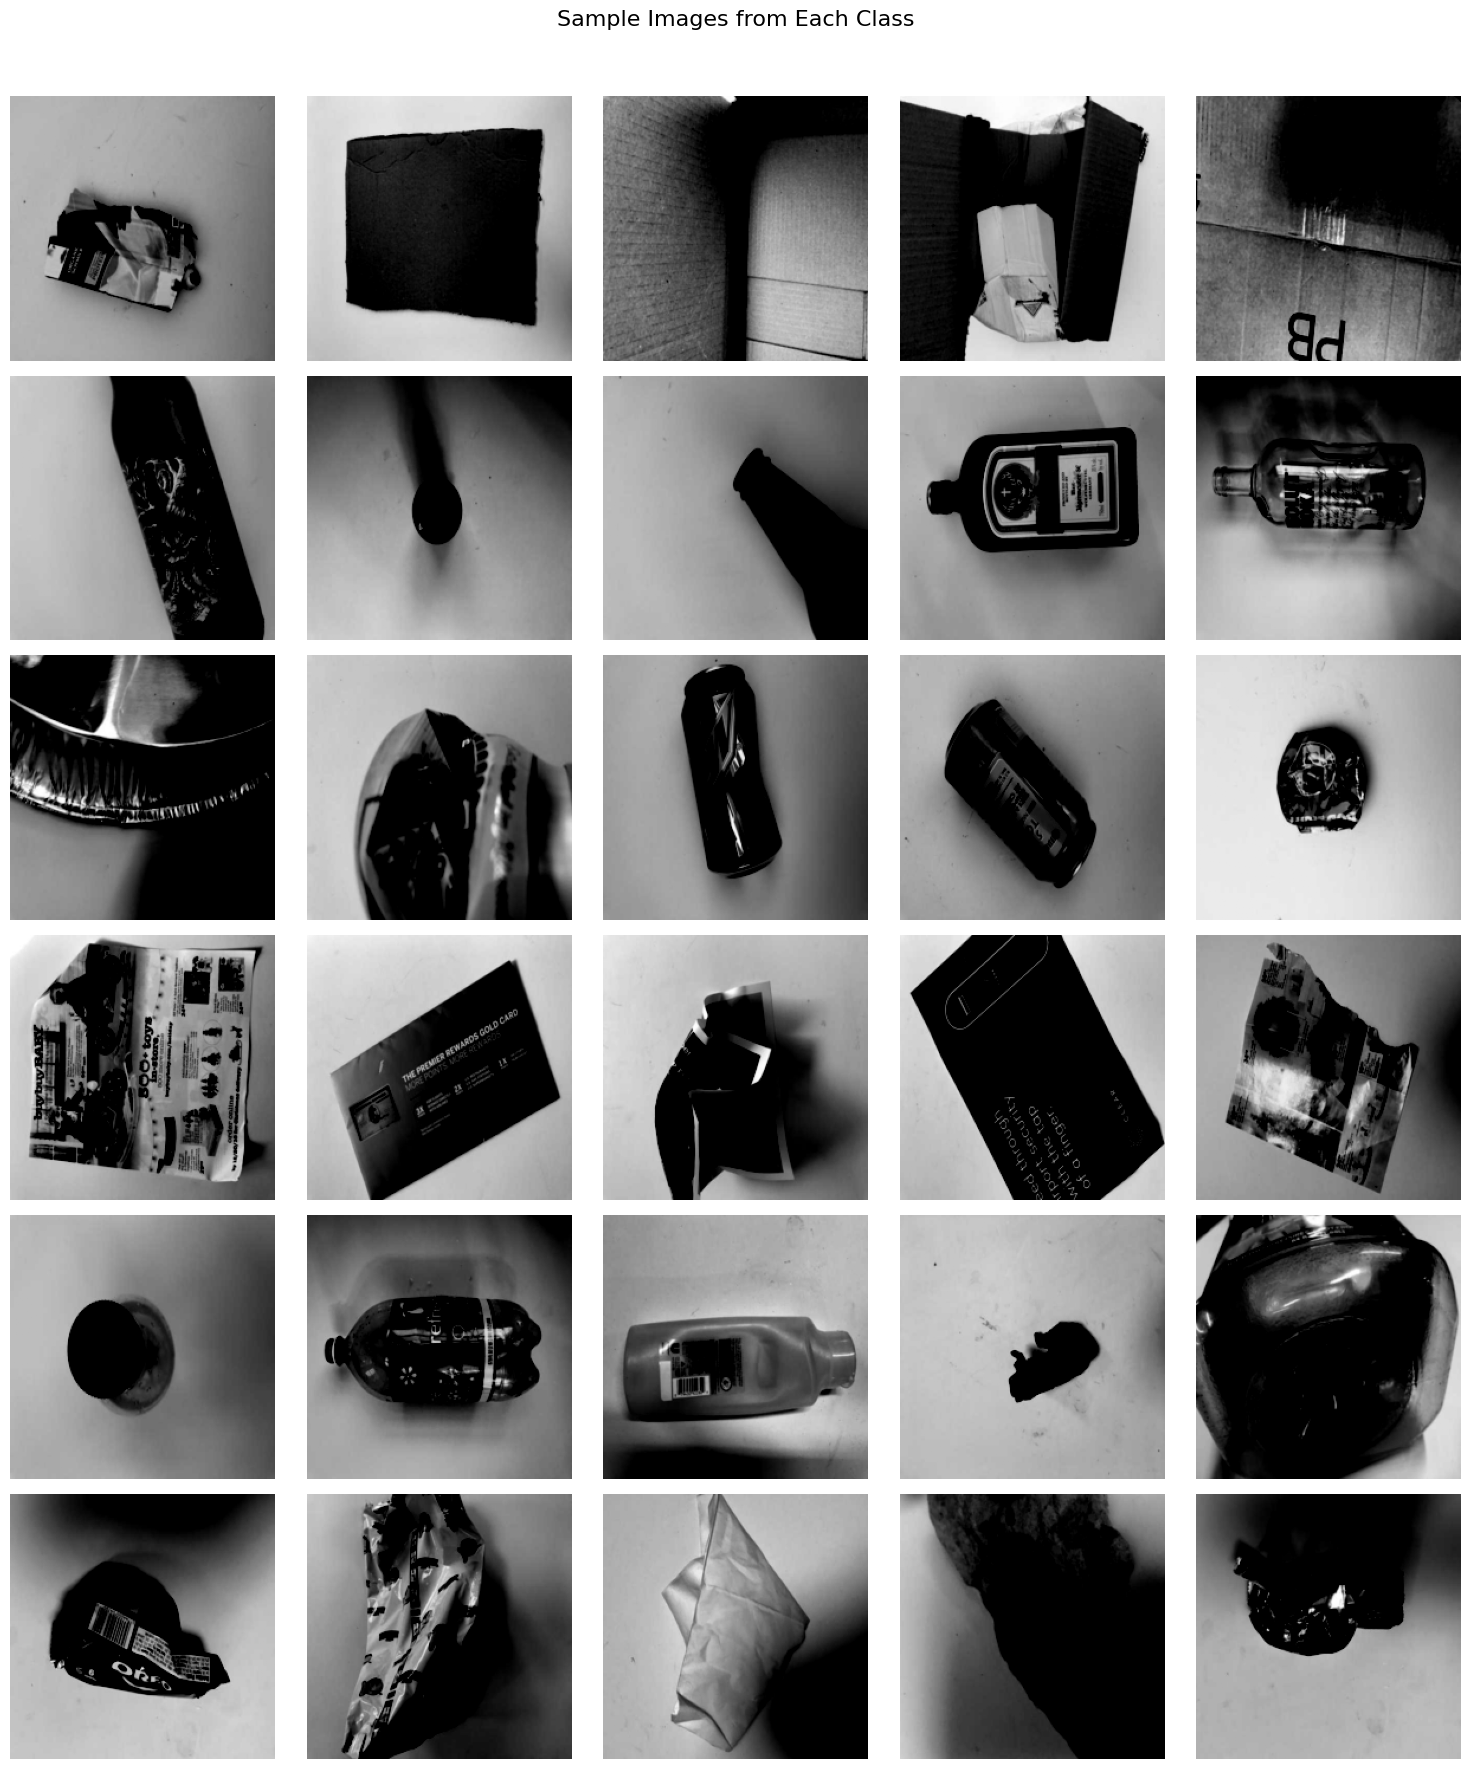

In [7]:
# 2. Menampilkan beberapa sampel dari tiap kelas
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 3, len(classes) * 3))
    fig.suptitle("Sample Images from Each Class", fontsize=16)
    
    for class_idx, class_name in enumerate(classes):
        class_indices = [i for i, label in enumerate(labels) if label == class_idx]
        selected_indices = np.random.choice(class_indices, num_samples, replace=False)
        
        for i, idx in enumerate(selected_indices):
            image, label = dataset[idx]
            ax = axes[class_idx, i]
            ax.imshow(image.permute(1, 2, 0))
            ax.axis('off')
            if i == 0:
                ax.set_ylabel(class_name, rotation=0, size='large', labelpad=40)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
# Tampilkan sampel
show_samples(dataset)

In [8]:
# 3. Memeriksa ukuran gambar rata-rata dan proporsi
image_shapes = [image.shape for image, _ in dataset]
avg_height = np.mean([shape[1] for shape in image_shapes])
avg_width = np.mean([shape[2] for shape in image_shapes])

print(f"Average image size (HxW): {avg_height:.2f} x {avg_width:.2f}")

Average image size (HxW): 224.00 x 224.00


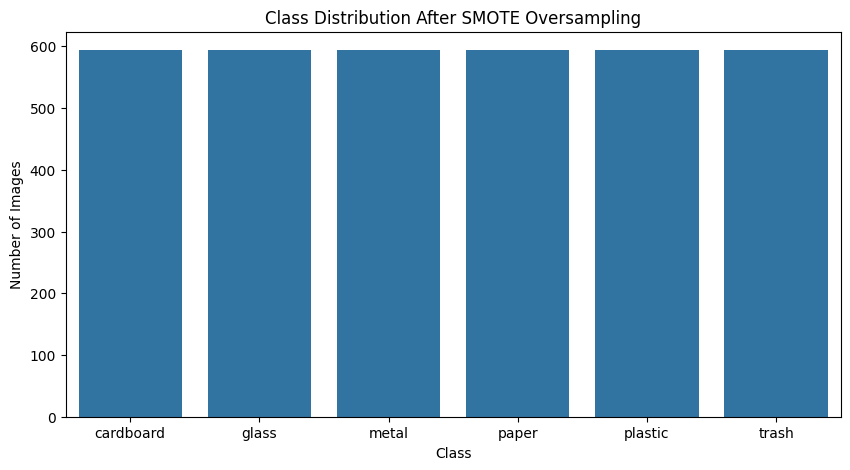

In [9]:
# 4. Visualisasi data setelah oversampling dengan SMOTE
# Memvisualisasikan distribusi kelas setelah oversampling
label_counts_resampled = Counter(labels_resampled)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(classes), y=[label_counts_resampled[i] for i in range(len(classes))])
plt.title("Class Distribution After SMOTE Oversampling")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [10]:
# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# # Define the model architecture
# class TrashClassifier(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(TrashClassifier, self).__init__()
#         self.fc1 = nn.Linear(input_size, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, num_classes)
    
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # Initialize the model
# num_classes = len(dataset.classes)
# model = TrashClassifier(input_size=features.shape[1], num_classes=num_classes)
# model.to(device)

# Define the model architecture
class TrashClassifier(nn.Module):
  def __init__(self, input_size, num_classes, dropout_rate=0.5):
    super(TrashClassifier, self).__init__()
    self.fc1 = nn.Linear(input_size, 256)
    self.dropout1 = nn.Dropout(dropout_rate)  # Add dropout layer after fc1
    self.fc2 = nn.Linear(256, 128)
    self.dropout2 = nn.Dropout(dropout_rate)  # Add dropout layer after fc2
    self.fc3 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = self.dropout1(x)  # Apply dropout to fc1 output
    x = torch.relu(self.fc2(x))
    x = self.dropout2(x)  # Apply dropout to fc2 output
    x = self.fc3(x)
    return x

# Initialize the model
num_classes = len(dataset.classes)
model = TrashClassifier(input_size=features.shape[1], num_classes=num_classes)
model.to(device)

TrashClassifier(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)

In [12]:
# Hyperparameters
learning_rate = 1e-4  # 0.0001
batch_size = 64
epochs = 50

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [13]:
# Initialize wandb
wandb.init(project="trash-classification", name="model-v1")
# Initialize wandb
wandb.init(
    project="trash-classification",
    name="model-V1",
    config={
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "model": "ResNet18",
        # "optimizer": "AdamW",  # ubah ke AdamW
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: muhammad-abdlhadi (muhammad-abdlhadi-universitas-esa-unggul). Use `wandb login --relogin` to force relogin


In [14]:
# Training the model with backpropagation
from sklearn.metrics import confusion_matrix

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    all_predictions = torch.tensor([])  # Initialize for confusion matrix
    all_labels = torch.tensor([])
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        optimizer.zero_grad()
        optimizer
        loss.backward()
        optimizer.step()
        # Calculate training metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Add predictions and labels for confusion matrix
        all_predictions = torch.cat((all_predictions, predicted.cpu()))
        all_labels = torch.cat((all_labels, labels.cpu()))
    
    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    # Evaluation phase
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * test_correct / test_total

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels.numpy(), all_predictions.numpy())
    
    # Log metrics to wandb (add confusion matrix)
    wandb.log({
        "Train Loss": epoch_loss,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Confusion Matrix": wandb.Image(cm, caption="Confusion Matrix")  # Assuming wandb is used for logging
    })
    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Training - Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"Testing  - Accuracy: {test_accuracy:.2f}%")
    print("-" * 50)

Epoch [1/50]
Training - Loss: 1.6978, Accuracy: 30.62%
Testing  - Accuracy: 59.33%
--------------------------------------------------
Epoch [2/50]
Training - Loss: 1.4338, Accuracy: 49.11%
Testing  - Accuracy: 64.10%
--------------------------------------------------
Epoch [3/50]
Training - Loss: 1.1998, Accuracy: 54.86%
Testing  - Accuracy: 66.48%
--------------------------------------------------
Epoch [4/50]
Training - Loss: 1.0660, Accuracy: 60.58%
Testing  - Accuracy: 67.18%
--------------------------------------------------
Epoch [5/50]
Training - Loss: 0.9546, Accuracy: 62.68%
Testing  - Accuracy: 71.81%
--------------------------------------------------
Epoch [6/50]
Training - Loss: 0.8775, Accuracy: 66.75%
Testing  - Accuracy: 71.67%
--------------------------------------------------
Epoch [7/50]
Training - Loss: 0.8247, Accuracy: 69.38%
Testing  - Accuracy: 73.77%
--------------------------------------------------
Epoch [8/50]
Training - Loss: 0.7675, Accuracy: 71.45%
Testing

In [15]:
# Evaluate the model
model.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

print(f"Epoch [{epoch+1}/{epochs}]")
print(f"Training - Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
print(f"Testing  - Accuracy: {test_accuracy:.2f}%")
print("-" * 50)

# Save the model
torch.save(model.state_dict(), "trash_classifier.pth")

# Log the model file to wandb
artifact = wandb.Artifact('model-v1', type='model')
artifact.add_file('trash_classifier.pth')
wandb.log_artifact(artifact)

#finish the wandb run, necessary in notebooks
wandb.finish()

Test Accuracy: 88.22%
Epoch [50/50]
Training - Loss: 0.2087, Accuracy: 92.88%
Testing  - Accuracy: 88.22%
--------------------------------------------------


Test Accuracy,▁▂▃▃▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████
Train Accuracy,▁▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
Train Loss,█▇▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,88.21879
Train Accuracy,92.87969
Train Loss,0.20868
